### Импорт

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

import xgboost as xgb
import catboost as cb

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

# Задача 1:
1. Проведите аналитику полученных данных
2. Подготовьте данные для регрессионной модели
3. Обучите регрессионную модель и осуществите прогноз на последний месяц для поля SALES
4. Оцените качество модели с помощью функции metric

### 1. Загрузка данных

In [2]:
df = pd.read_csv(r'D:\junior__test_DS\junior\regression\data_regression_for_task.csv')

In [3]:
df.head(10)

,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES
0,2017,4,ROYAL WINE CORP,100200,GAMLA CAB - 750ML,WINE,0.0,0.0
1,2017,4,SANTA MARGHERITA USA INC,100749,SANTA MARGHERITA P/GRIG ALTO - 375ML,WINE,0.0,0.0
2,2017,4,JIM BEAM BRANDS CO,10103,KNOB CREEK BOURBON 9YR - 100P - 375ML,LIQUOR,0.0,0.0
3,2017,4,HEAVEN HILL DISTILLERIES INC,10120,J W DANT BOURBON 100P - 1.75L,LIQUOR,0.0,0.0
4,2017,4,ROYAL WINE CORP,101664,RAMON CORDOVA RIOJA - 750ML,WINE,0.0,0.0
5,2017,4,REPUBLIC NATIONAL DISTRIBUTING CO,101680,MANISCHEWITZ CREAM WH CONCORD - 1.5L,WINE,0.0,0.0
6,2017,4,ROYAL WINE CORP,101753,BARKAN CLASSIC PET SYR - 750ML,WINE,0.0,0.0
7,2017,4,JIM BEAM BRANDS CO,10197,KNOB CREEK BOURBON 9YR - 100P - 1.75L,LIQUOR,0.0,0.0
8,2017,4,STE MICHELLE WINE ESTATES,101974,CH ST MICH P/GRIS - 750ML,WINE,0.0,0.0
9,2017,4,MONSIEUR TOUTON SELECTION,102083,CH DE LA CHESNAIE MUSCADET - 750ML,WINE,0.0,0.0


**Описание:**

* YEAR: год продажи
* MONTH: месяц продажи
* CONTRAGENT: поставщик товарной позиции
* ARTICLE_CODE: код товарной позиции
* ARTICLE_NAME: название товарной позиции
* ARTICLE_GROUP: название группы товарных позиций
* SALES: продажи товарной позиции в этот месяц и год (целевая переменная)
* STORE_SALES: продажи всего магазина

### 2. Анализ данных

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128355 entries, 0 to 128354
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   YEAR           128355 non-null  int64  
 1   MONTH          128355 non-null  int64  
 2   CONTRAGENT     128331 non-null  object 
 3   ARTICLE_CODE   128355 non-null  object 
 4   ARTICLE_NAME   128355 non-null  object 
 5   ARTICLE_GROUP  128354 non-null  object 
 6   SALES          128355 non-null  float64
 7   STORE_SALES    128355 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 7.8+ MB


In [5]:
df.describe()

,YEAR,MONTH,SALES,STORE_SALES
count,128355.000000,128355.000000,1.283550e+05,128355.000000
mean,2017.206030,7.079303,6.563037e+03,22.624213
std,0.404454,3.645826,2.892494e+04,239.693277
min,2017.000000,1.000000,-6.490000e+03,-4996.000000
25%,2017.000000,5.000000,0.000000e+00,0.000000
50%,2017.000000,8.000000,3.300000e+02,1.000000
75%,2017.000000,10.000000,3.250000e+03,4.000000
max,2018.000000,12.000000,1.616600e+06,16271.750000


1. В данных содержатся пропуски, которые необходимо удалить. В данном случае мы из просто отбросим, т.к. их не много.
2. В признаках `SALES` и `STORE_SALES` присутствуют существенные выбросы, а также отрицательные значения. Природа выбросов не совсем понятна, но отрицательно скажется на качестве модели. Поэтому данные с выбросами использоваться для обучения не будут. В качестве границы отсечения я выбрал значение, чтобы потерять не более 5% данных. Это значения 50000 и 100 для `SALES`  и `STORE_SALES` соответственно.

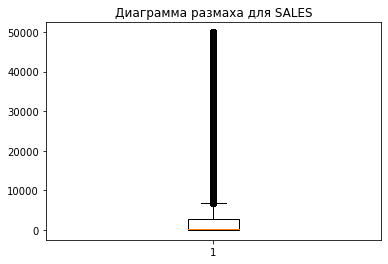

In [6]:
df=df.query('(SALES<50000) & (SALES>=0)')
plt.boxplot(df['SALES'])
plt.title('Диаграмма размаха для SALES')
plt.show()

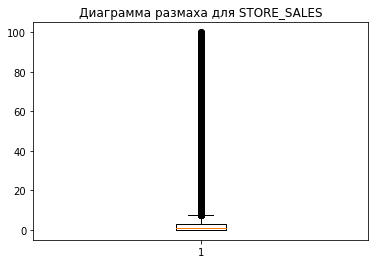

In [7]:
df=df.query('0<=STORE_SALES<100')
plt.boxplot(df['STORE_SALES'])
plt.title('Диаграмма размаха для STORE_SALES')
plt.show()

Для обучения также будут использоваться признаки `CONTRAGENT` и `ARTICLE_GROUP`, в качестве категориальных признаков, кодированных One-Hot-Encoding.

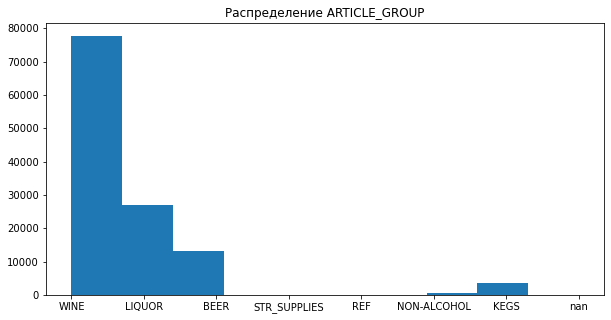

In [8]:
plt.figure(figsize=(10,5))
plt.hist(df['ARTICLE_GROUP'])
plt.title('Распределение ARTICLE_GROUP')
plt.show()

### 3. Подготовка признаков и выборок

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122194 entries, 0 to 128352
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   YEAR           122194 non-null  int64  
 1   MONTH          122194 non-null  int64  
 2   CONTRAGENT     122194 non-null  object 
 3   ARTICLE_CODE   122194 non-null  object 
 4   ARTICLE_NAME   122194 non-null  object 
 5   ARTICLE_GROUP  122193 non-null  object 
 6   SALES          122194 non-null  float64
 7   STORE_SALES    122194 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 8.4+ MB


In [10]:
# удаление пропусков
df.dropna(inplace=True)

# удаление неиспользуемых признаков
df = df.drop(['ARTICLE_CODE', 'ARTICLE_NAME'], axis=1)

In [11]:
# кодирование OHE
df=pd.get_dummies(df, columns=['CONTRAGENT', 'ARTICLE_GROUP'])

In [12]:
# разбивка на train-test
# в тесте - февраль 2018 г.
df_train = df.query('YEAR!=2018 & MONTH!=2')
df_test = df.query('YEAR==2018 & MONTH==2')

Разбиваем данные для трейн\тест.

In [13]:
X_train = df_train.drop(['SALES'], axis=1)
y_train = df_train['SALES']

X_test = df_test.drop(['SALES'], axis=1)
y_test = df_test['SALES']

print('Features train:', X_train.shape)
print('Target train:', y_train.shape)
print('Features test:', X_test.shape)
print('Target test:', y_test.shape)

Features train: (96935, 343)
Target train: (96935,)
Features test: (12511, 343)
Target test: (12511,)


### 4. Обучение и тестирование модели

In [14]:
# метирика
def metric(y_true, y_pred):
    
    return np.sum(np.abs(y_true - y_pred)) / np.sum(y_pred) * 100

In [15]:
# дата-фрейм для результатов
results = pd.DataFrame(columns=['Metric'])

#### 4.1 Dummy-модели (константная медиана и среднее)

In [16]:
pred_median = np.full(y_test.shape, np.median(y_train))
pred_mean = np.full(y_test.shape, np.mean(y_train))

results.loc['Constant_Median'] = metric(y_test, pred_median)
results.loc['Constant_Mean'] = metric(y_test, pred_mean)

print('Метрика для константной модели(медиана):', metric(y_test, pred_median))
print('Метрика для константной модели(среднее):', metric(y_test, pred_mean))

Метрика для константной модели(медиана): 1303.8269656036023
Метрика для константной модели(среднее): 128.45729210520201


#### 4.2 LinearRegression

In [17]:
lr_m=LinearRegression()
lr_m.fit(X_train,y_train)
lr_pred = lr_m.predict(X_test)

results.loc['LinearRegression']=metric(y_test, lr_pred)

print('Метрика для модели линейной регрессии:', metric(y_test, lr_pred))

Метрика для модели линейной регрессии: 178.57586394596115


#### 4.3 XGBoostRegressor

In [18]:
def XGB_cv_grid():
    xgb_m = xgb.XGBRegressor(random_state=112211)
    param_grid = {
            "n_estimators"      : [200,],
            "learning_rate"     : [0.1, 1],
            "max_depth" : [20],
            "gamma" : [0.1],
            "reg_lambda": [5],
            "min_child_weight" : [4]
            }

    xgb_grid = GridSearchCV(xgb_m, param_grid, n_jobs=-1, cv=3, scoring='neg_root_mean_squared_error')
    xgb_grid.fit(X_train, y_train)

    print('...Search completed...')
    print('Best params:', xgb_grid.best_params_)
    return xgb_grid.best_params_

In [19]:
#xgb_params = XGB_cv_grid()
xgb_params={'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 20, 'min_child_weight': 4, 'n_estimators': 100, 'reg_lambda': 5}

In [20]:
xgb_model = xgb.XGBRegressor(**xgb_params)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=20,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=5, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [21]:
xgb_pred = xgb_model.predict(X_test)

In [22]:
results.loc['XGBRegressor']=metric(y_test, xgb_pred)
print('Метрика для модели XGBRegressor:', metric(y_test, xgb_pred))

Метрика для модели XGBRegressor: 112.98502127941205


### Результаты:

Входными данными были данные о продаже различных товаров в магазине по месяцам. 

Данные были обработаны, удалены пропуски и выбросы. Были подготовлены признаки для обучения моделей. В качестве целевого признака выступала сумма продаж `SALES`.
Тестовые данные - данные на последний месяц (февраль 2018 г.).

Были обучены различные модели и рассчитана целевая метрика для каждой из них. Лучшие значения метрики показаны на бустинговой модели.

**Предложения для развития:**
1. Понять природу выбросов и пропусков в данных.
2. Собрать больше признаков для обучения, больший диапазон по времени.
3. Тюнинг бустинговой модели для повышения целевой метрики.


In [23]:
results

,Metric
Constant_Median,1303.826966
Constant_Mean,128.457292
LinearRegression,178.575864
XGBRegressor,112.985021


# Задача 2.
1. Проведите аналитику полученных данных
2. Подготовьте данные для модели классификации
3. Обучите модель классификации и осуществите прогноз для отложенной выборки с учетомо перекоса в данных TARGET
4. Оцените качество модели с помощью функции f1_score

### 1. Загрузка данных

In [24]:
data=pd.read_csv('D:\junior__test_DS\junior\classification\data_classification_for_task.csv')

In [25]:
data.head()

,AGE,GENDER,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,FEATURE_8,FEATURE_9,FEATURE_10,FEATURE_11,TARGET
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


**Описание:**
* AGE: возраст пациента
* GENDER: пол пациента
* FEATURE1-11: характеристики здоровья сердечно-сосудстой системы пациента
* TARGET: болен/не болен (целевая переменная)

### 2. Анализ данных

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   AGE         303 non-null    int64  
 1   GENDER      303 non-null    int64  
 2   FEATURE_1   303 non-null    int64  
 3   FEATURE_2   303 non-null    int64  
 4   FEATURE_3   303 non-null    int64  
 5   FEATURE_4   303 non-null    int64  
 6   FEATURE_5   303 non-null    int64  
 7   FEATURE_6   303 non-null    int64  
 8   FEATURE_7   303 non-null    int64  
 9   FEATURE_8   303 non-null    float64
 10  FEATURE_9   303 non-null    int64  
 11  FEATURE_10  303 non-null    int64  
 12  FEATURE_11  303 non-null    int64  
 13  TARGET      303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [27]:
data.describe()

,AGE,GENDER,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,FEATURE_8,FEATURE_9,FEATURE_10,FEATURE_11,TARGET
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


В данных явно выделяются количественные и категориальные признаки. Разделим их и посмотрим на распределения, чтобы обнаружить потенциальные аномалии.

In [28]:
cat_features = ['GENDER', 'FEATURE_1', 'FEATURE_4', 'FEATURE_5', 'FEATURE_7', 'FEATURE_9', 'FEATURE_10', 'FEATURE_11']
num_features = ['AGE', 'FEATURE_2', 'FEATURE_3', 'FEATURE_6', 'FEATURE_8']

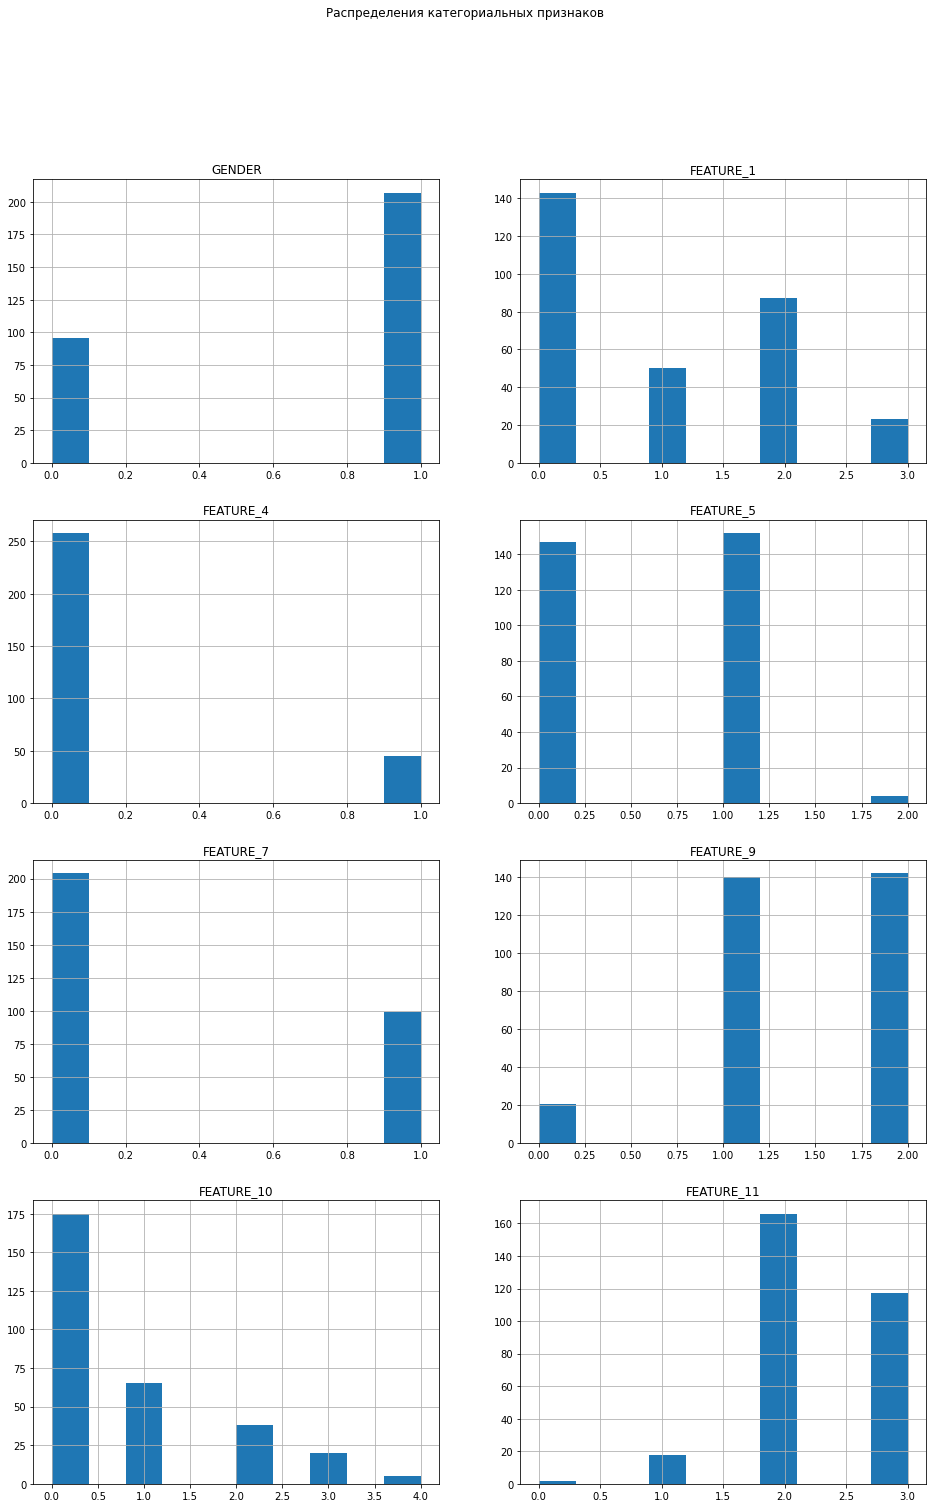

In [29]:
plt.figure(figsize=(16,24))
plt.suptitle('Распределения категориальных признаков')
i=1
for col in cat_features:
    plt.subplot(4, 2, i)
    plt.hist(data[col])
    plt.title(col)
    plt.grid()
    i+=1
plt.show()

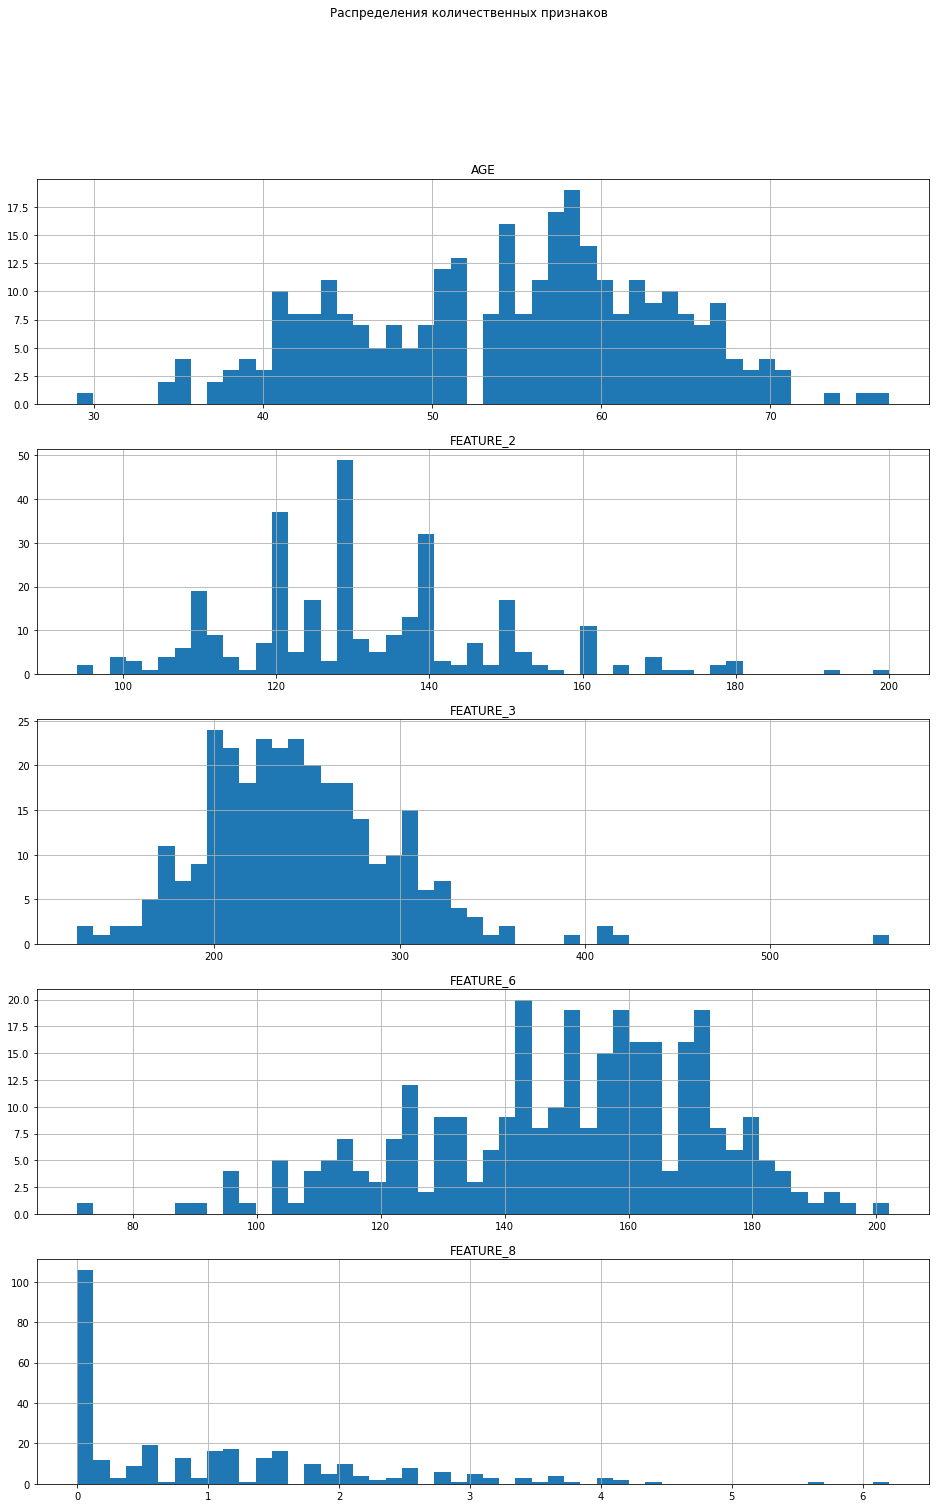

In [30]:
plt.figure(figsize=(16,24))
i=1
plt.suptitle('Распределения количественных признаков')
for col in num_features:
    plt.subplot(5, 1, i)
    plt.hist(data[col], bins=50)
    plt.title(col)
    plt.grid()
    i+=1
plt.show()

Сильных аномалий не обнаружено. Анализируем целевой признак.

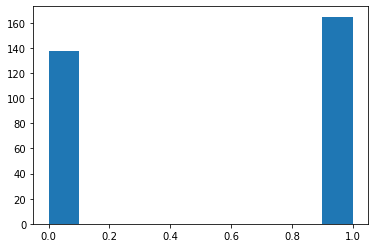

In [31]:
target = data['TARGET']
plt.hist(target)
plt.show()

Имеется небольшой дисбаланс классов. Но не критичный. Будем использовать балансировку весов при обучении моделей.

### 3. Подготовка признаков

In [32]:
features=data.drop(['TARGET'], axis=1)

In [33]:
# кодируем категориальные признаки OHE
features = pd.get_dummies(features, columns=cat_features)

In [34]:
# разбиваем на трейн-тест выборки
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=12345)
print('Features train:', X_train.shape)
print('Target train:', y_train.shape)
print('Features test:', X_test.shape)
print('Target test:', y_test.shape)

Features train: (242, 30)
Target train: (242,)
Features test: (61, 30)
Target test: (61,)


In [35]:
# нормируем количественные признаки через StandartScaler
scaler = StandardScaler()
scaler.fit(X_train[num_features])

X_train[num_features]=scaler.transform(X_train[num_features])
X_test[num_features]=scaler.transform(X_test[num_features])

In [36]:
X_train.head()

,AGE,FEATURE_2,FEATURE_3,FEATURE_6,FEATURE_8,GENDER_0,GENDER_1,FEATURE_1_0,FEATURE_1_1,FEATURE_1_2,...,FEATURE_9_2,FEATURE_10_0,FEATURE_10_1,FEATURE_10_2,FEATURE_10_3,FEATURE_10_4,FEATURE_11_0,FEATURE_11_1,FEATURE_11_2,FEATURE_11_3
97,-0.259200,-1.291693,-0.218907,-0.085712,-0.780635,0,1,1,0,0,...,1,0,0,0,1,0,0,0,0,1
224,-0.035177,-1.180154,-0.097357,-0.985683,1.631028,0,1,1,0,0,...,0,0,1,0,0,0,0,0,0,1
174,0.636892,-0.064758,-0.765880,-0.728548,1.273745,0,1,1,0,0,...,0,0,0,1,0,0,0,0,0,1
53,-1.155292,-1.291693,-2.082668,1.114250,-0.334030,1,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
234,1.757007,-0.064758,1.584080,-1.714231,1.273745,0,1,1,0,0,...,0,0,0,0,1,0,0,0,1,0


Всё готово для обучения и тестирования.

### 4. Обучение и тестирование моделей

In [37]:
# функция для тестирования и скоринга
def test_me(cur_model):    
    probabilities_test = cur_model.predict_proba(X_test)
    probabilities_one_test = probabilities_test[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)
    
    # F1 score
    predictions = cur_model.predict(X_test)
    f1=f1_score(y_test, predictions)
    print('F1_Score=',f1)
    
    #график
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    
    plt.show()  
    return f1

In [38]:
results_class = pd.DataFrame(columns=['F1_Score'])

#### 4.1 Dummy-модель (только класс 1)

In [39]:
dummy_pred = np.full(y_test.shape, 1)
print('F1-score для константной модели(только 1):', f1_score(y_test, dummy_pred))

results_class.loc['Constant_ones']=f1_score(y_test, dummy_pred)

F1-score для константной модели(только 1): 0.7422680412371134


#### 4.2 LogisticRegression (baseline)

In [40]:
logr_m=LogisticRegression(class_weight='balanced')
logr_m.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

F1_Score= 0.7692307692307692


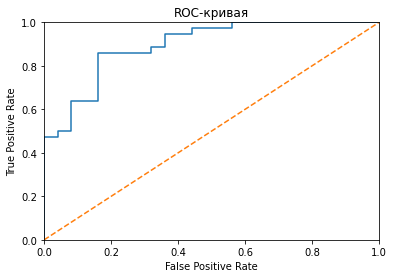

In [41]:
logr_f1 = test_me(logr_m)
results_class.loc['LogisticRegression']=logr_f1

Оценим важность признаков на примере логистической регрессии.

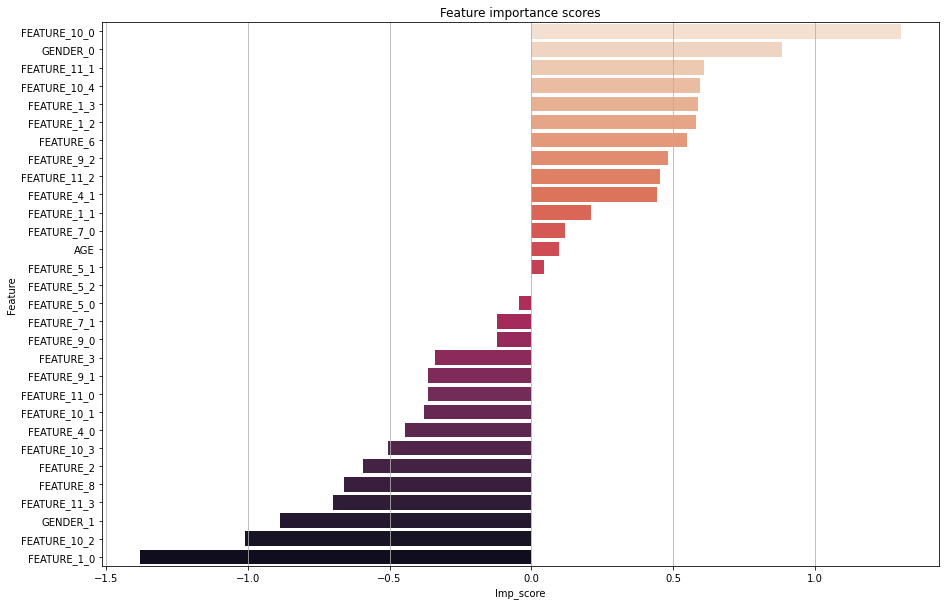

In [42]:
# посмотрим на примере лог.регрессии
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)

importance = model.coef_[0]

# собираем датафрейм с данными
feat_imp=pd.DataFrame()
feat_imp['Feature']=X_train.columns
feat_imp['Imp_score'] = importance

# строим график
plt.figure(figsize=(15,10))
plt.grid(axis='both', which='both')
plt.title('Feature importance scores')
sns.barplot(x='Imp_score', y='Feature', data=feat_imp.sort_values(by='Imp_score', ascending=False), palette='rocket_r')
plt.show()

`FEATURE_5` и `AGE` оказывают небольшое влияние на результаты. В целом, для дальнейшего совершенствования модели, их можно будет не учитывать.

#### 4.3 CatboostClassifier

In [43]:
def CB_cv_grid():
    cb_m = cb.CatBoostClassifier(random_state=112211)
    param_grid = {
            "iterations"        : [2000],
            "learning_rate"     : [0.1, 1],
            "l2_leaf_reg" : [6],
            "max_depth": [6],
            "max_leaves" : [31],
            'verbose' : [0],
            'auto_class_weights': ['Balanced']
            }

    lgb_grid = GridSearchCV(cb_m, param_grid, n_jobs=-1, cv=3, scoring='f1')
    lgb_grid.fit(X_train, y_train)

    print('...Search completed...')
    print('Best params:', lgb_grid.best_params_)
    return lgb_grid.best_params_

In [44]:
cb_params=CB_cv_grid()

...Search completed...
Best params: {'auto_class_weights': 'Balanced', 'iterations': 2000, 'l2_leaf_reg': 6, 'learning_rate': 0.1, 'max_depth': 6, 'max_leaves': 31, 'verbose': 0}


In [45]:
cbc_m=cb.CatBoostClassifier(**cb_params)
cbc_m.fit(X_train, y_train)

F1_Score= 0.8125000000000001


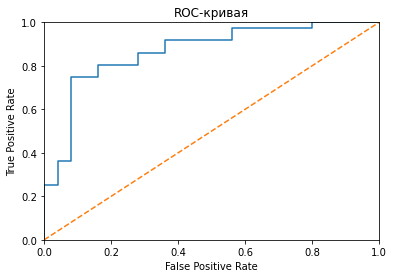

In [46]:
cb_f1 = test_me(cbc_m)
results_class.loc['CatBoostClassifier']=cb_f1

### 5. Результаты

Входными данными были данные о пациентах и характеристики их сердечно-сосудистой системы. Целевой признак для классификации - болен пациент или нет.

Данные были обработаны и проанализированы. Аномалий, пропусков не обнаружено.

Были выделены количественные и категориальные признаки для обучения. Количественные были стандартизованы, категориальные закодированы One-Hot-Encoding. Данные были разбиты на тренировочную и тестовую выборки. <br/>
На основе логистической регрессии был проведён анализ влияния признаков на качество прогноза.

Были обучены и протестированы несколько моделей: константная (только класс 1), логистическая регрессия и бустинговая модель CatBoost. В качестве целевой метрики использовалась F1_score. <br/>

**Предложения** дальнейшего развитие для улучшения качества предсказаний:
* Собрать больше данных
* Выделить наиболее важные признаки
* Тюнинг модели для повышения целевой метрики

Результаты моделирования:

In [47]:
results_class

,F1_Score
Constant_ones,0.742268
LogisticRegression,0.769231
CatBoostClassifier,0.812500
